<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Deep Learning School FPMI MIPT</b></h3>

<h3 style="text-align: center;"><b>Generative adversarial networks</b></h3>



In [1]:
import os
import time
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Part 1. Data prepare

As a training sample, we will take a part of the [Flickr Faces] dataset (https://github.com/NVlabs/ffhq-dataset), which contains images of people's faces in high resolution (1024x1024). The original dataset is very large, so we will take a part of it. You can download the dataset [here](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Let's upload our images. Let's write a function that builds a DataLoader for images, while changing their size to the desired value

In [2]:
DATA_DIR = './faces_dataset_small/'
IMAGE_SIZE = 128
BATCH_SIZE = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [3]:
def get_dataloader(image_size = IMAGE_SIZE, batch_size = BATCH_SIZE):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
            tt.Resize(image_size),
            tt.CenterCrop(image_size),
            tt.ToTensor(),
            tt.Normalize(*stats)]))
    return DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
#TODO: build dataloader and transfer it to device
train_dl = get_dataloader()

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

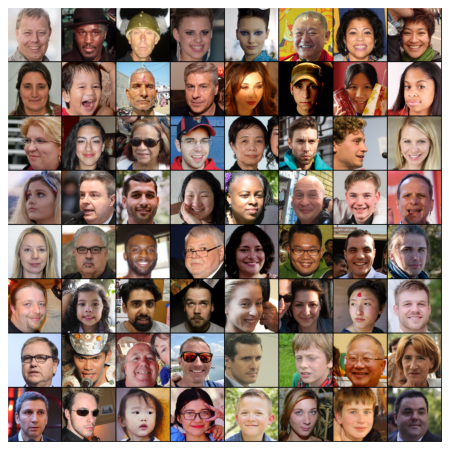

In [7]:
show_batch(train_dl)

In [8]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
train_dl = DeviceDataLoader(train_dl, device)

## Part 2. Building and training the model

In [76]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8
    
    #nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    #nn.BatchNorm2d(1024),
    #nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4

    #nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Conv2d(512, 1, kernel_size=8, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [77]:
discriminator = to_device(discriminator, device)

In [78]:
latent_size = 128 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=8, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 1024 x 4 x 4 

    #nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    #nn.BatchNorm2d(512),
    #nn.ReLU(True),
    # out: 512 x 8 x 8 

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16 

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32 

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64 

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128 
)

torch.Size([64, 3, 128, 128])


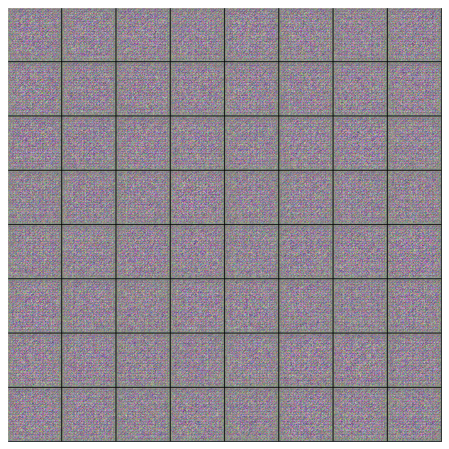

In [63]:
xb = torch.randn(BATCH_SIZE, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [79]:
generator = to_device(generator, device)

Now let's move on to training our GAN. The learning algorithm is as follows:
1. Learn the discriminator:
   * take real images and assign label 1 to them
   * generate images with a generator and assign them a label of 0
   * train the classifier for two classes

2. Learn the generator:
   * generate images with a generator and assign them a label of 0
   * predict with a discriminator whether the image is real or not


As a loss function, we take the binary cross-entropy

In [15]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [65]:
fixed_latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=device)

In [17]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [80]:
lr = 0.0001
epochs = 30
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [73]:
def fit(model, criterion, epochs, lr):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(BATCH_SIZE, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+1, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [74]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/3], loss_g: 13.5724, loss_d: 0.0041, real_score: 0.9984, fake_score: 0.0023


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/3], loss_g: 18.2048, loss_d: 0.1749, real_score: 0.9911, fake_score: 0.0321


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/3], loss_g: 18.8327, loss_d: 0.0947, real_score: 0.9914, fake_score: 0.0224
Saving generated-images-0003.png


Let's visualise losses

In [28]:
losses_g, losses_d, real_scores, fake_scores = history

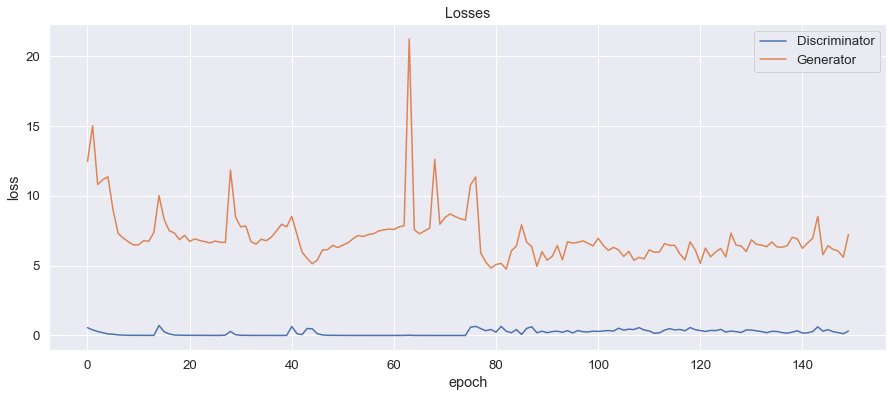

In [29]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

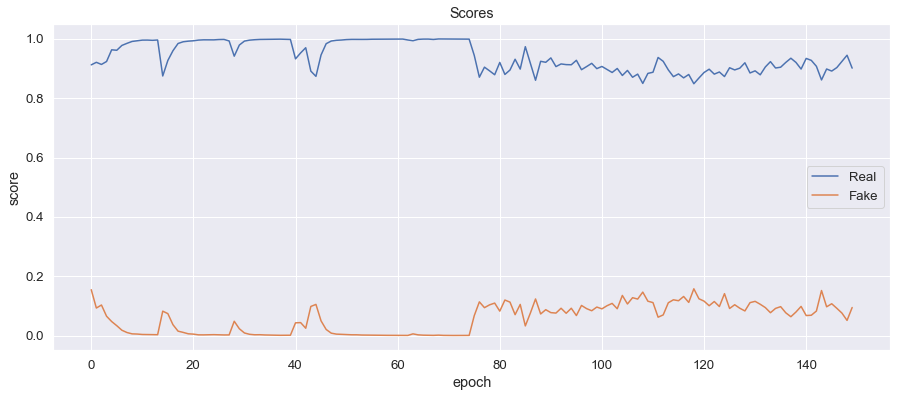

In [30]:
plt.figure(figsize=(15, 6))
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [82]:
model['discriminator'].load_state_dict(torch.load('discriminator.pth'))
model['generator'].load_state_dict(torch.load('generator.pth'))

<All keys matched successfully>

## Part 3. Image generation

Now let's evaluate the quality of the resulting images. Let's write a function that displays the images generated by our generator

In [83]:
def show_generated_img(n_images):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, latent_size, 1, 1, device=device)
        gen_image =  model["generator"](noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
    
    figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


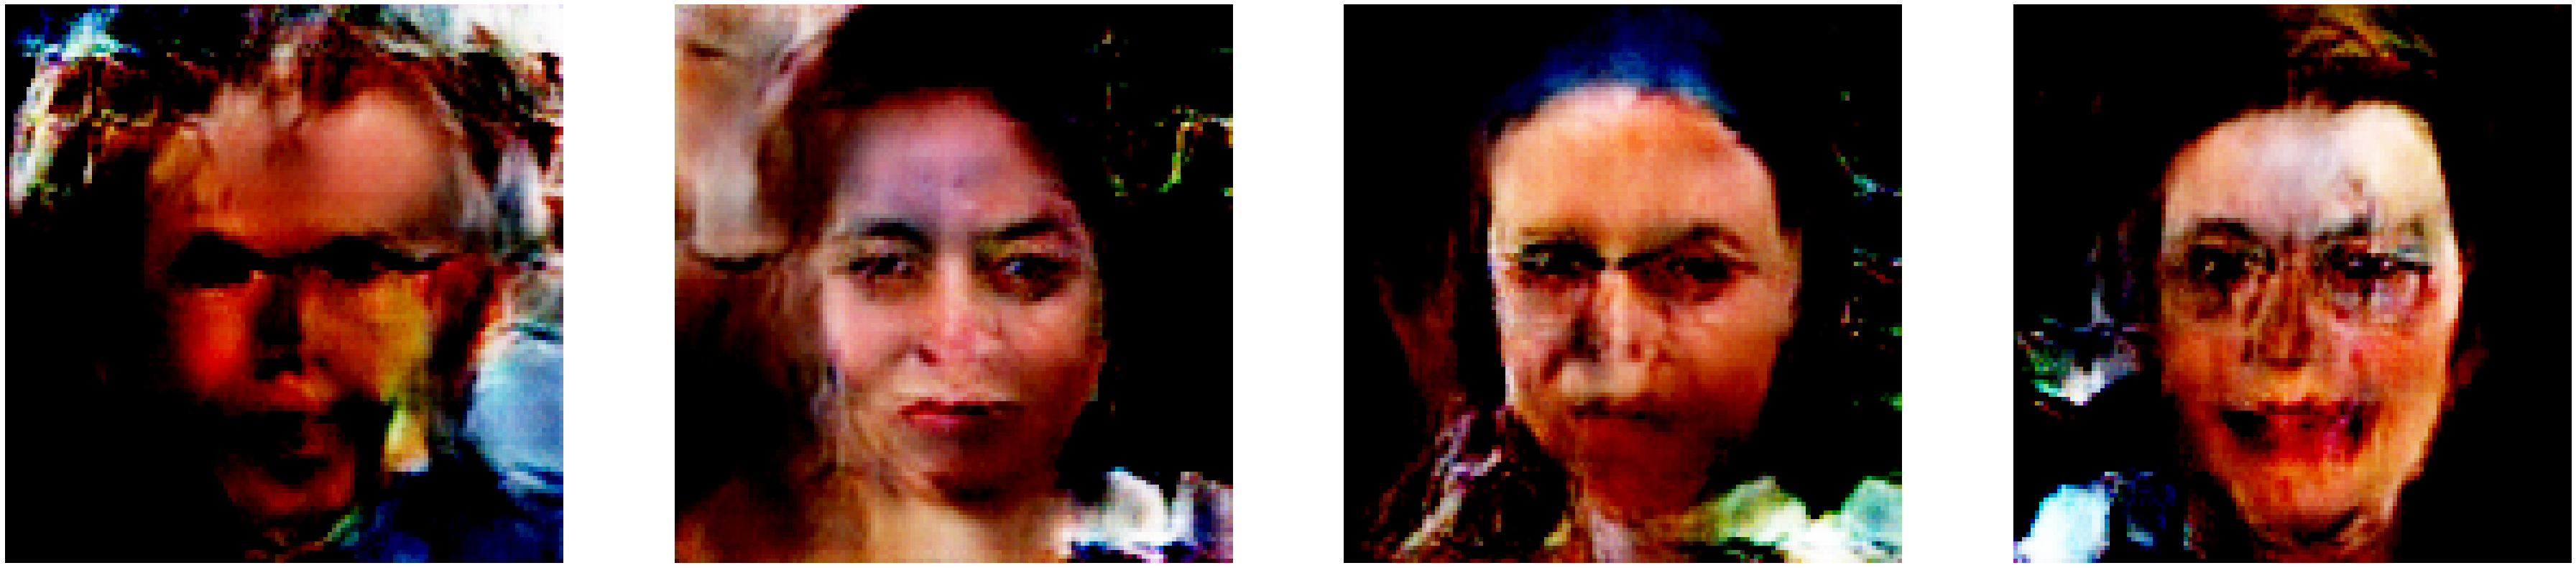

In [94]:
show_generated_img(4)

The resulting images remotely resemble people's faces, which indicates the need for additional training or changing the parameters in the model.

## Part 4. Leave-one-out-1-NN classifier accuracy

### 4.1. Calculating accuracy

It is not always convenient to evaluate the quality of generated images with your eyes. As an alternative, it is proposed to implement the following approach:
   * Generate as many fake images as there are real ones in the training set. Assign class 0 to fake ones, class 1 to real ones.
   * Build leave-one-out estimate: train 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) to predict class on all objects except one, check accuracy on remaining object. This will help you `sklearn.model_selection.LeaveOneOut`

In [154]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [155]:
cv = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1)

In [131]:
test_dl = get_dataloader(batch_size = 1)

In [161]:
model["generator"].to('cpu').eval()
noises = torch.randn(len(test_dl)-1, latent_size, 1, 1)
fake_images = model["generator"](noises)
fake_labels = torch.zeros(fake_images.size(0), 1)

In [158]:
data = ImageFolder(DATA_DIR, transform=tt.Compose([
            tt.Resize(128),
            tt.CenterCrop(128),
            tt.ToTensor(),
            tt.Normalize(*stats)]))
real_images = data
real_labels = torch.ones(len(data), 1)

In [163]:
all_labels = torch.cat((fake_labels, real_labels))

temp = []
for img, _ in tqdm(data):
    temp.append(img)
    
all_imgs = torch.cat((fake_images, torch.stack(temp)))

  0%|          | 0/3143 [00:00<?, ?it/s]

In [166]:
all_imgs.shape

torch.Size([6285, 3, 128, 128])

In [168]:
idx = np.arange(len(all_imgs))
np.random.shuffle(idx)
idx = idx[:3142]
X = all_imgs.view(6285, -1).detach().numpy()[idx]
y = all_labels.detach().numpy().ravel()[idx]

In [169]:
scores = cross_val_score(knn, X, y, scoring='accuracy', cv=cv, n_jobs=-1, verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 3142 out of 3142 | elapsed: 21.6min finished


In [175]:
print('Accuracy: %.3f' % (np.mean(scores)))

Accuracy: 0.809


The closer the accuracy is to 0.5, the less difference the model sees between the images of the generator and the dataset. In our case, the resulting score indicates not the best quality of the generator model.

### 4.2. Visualization of distributions

Let's look at how similar the distributions of real and fake images are. To do this, we use a method that reduces the dimension (for example, TSNE) and draw points on the graph with different colors corresponding to real and generated images.

In [176]:
X = all_imgs.view(6285, -1).detach().numpy()
y = all_labels.detach().numpy().ravel()

In [172]:
from sklearn.manifold import TSNE

In [173]:
tsne = TSNE(n_iter=300)
tsne_results = tsne.fit_transform(X)

C:\Users\amorf\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\amorf\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


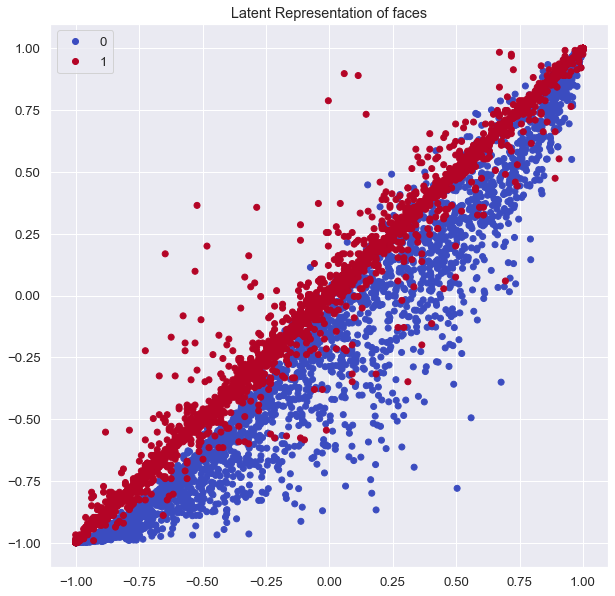

In [182]:
fig = plt.figure( figsize=(10,10) )
ax = fig.add_subplot(1, 1, 1, title='Latent Representation of faces' )
scatter = ax.scatter(
    x=X[:,0], 
    y=X[:,1], 
    c=y, 
    cmap=plt.cm.get_cmap('coolwarm'))
    
ax.legend(*scatter.legend_elements(), loc='upper left')
plt.show()

The graph clearly shows how the generated and real images are separated. The fact that the evaluation model easily finds differences between them indicates the low quality of the generative network.